In [23]:
# Data
from pymongo import MongoClient # For cluster connections, also requires dnspython package
from urllib.parse import urlparse
import pandas as pd
import numpy as np
import os
import random
import re
import tqdm

# Preprocessing
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import preprocessor as p

# Gensim LDA
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Lemmatization
import spacy # python -m spacy download en_core_web_sm

# Plotting
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from wordcloud import WordCloud, STOPWORDS
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dillo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
"""Set environment variable for connection string"""
%env MONGODB_CONNECTION=

In [25]:
class MongoDBConnect():
    """The Mongo database connector
    Args:
        host: host to connect
    """

    def __init__(self, host):
        self.host = host
        self.connection = None

    def __enter__(self):
        self.connection = MongoClient(self.host)
        print('Mongo connection created: {0}'.format(self.connection))
        return self

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.connection.close()

    def get_all(self, collection, limit=0, order=1):
        """
        MongoDB get all items
        Args:
            collection: collection to get from
            limit: integer of limit of items to retrieve, ie, 1000, 2000, etc.
            order: datetime sort: asc 1, desc -1
        """
        try:
            collection = self.connection[urlparse(
                self.host).path[1:]][collection]
            items = collection.find().sort('created_at', order).limit(limit)  # oldest default, no limit default
            print('Successfully found {0} items'.format(items.count(with_limit_and_skip=True)))
            return items
        except Exception as e:
            print('PyMongo database error: {0}'.format(str(e)))
            raise e


In [ ]:
conn = os.getenv("MONGODB_CONNECTION")
with MongoDBConnect(conn) as db:
    items = db.get_all(collection="tweets", limit=250000)
    df = pd.DataFrame.from_dict(items)

In [27]:
# Load stop words and spacy nlp tokenizer
stop_words = stopwords.words('english')
nlp = spacy.load("en_core_web_sm")

In [28]:
# Clean tweets
def preprocess_tweet(text):
    return p.clean(text)

# Get hashtags
def preprocess_hashtags(text):
    hashtags = p.parse(df["tweet"][0]).hashtags
    return [hashtag.match for hashtag in hashtags]

In [29]:
# Preprocessing
df["hashtag"] = df["tweet"].apply(lambda x: preprocess_hashtags(x)) # Get hashtags for future analysis
df["day"] = df["created_at"].dt.day # Get day for temporal analysis (topic evolution by day)
df["tweet"] = df["tweet"].apply(lambda x: preprocess_tweet(x)) # Twitter preprocessing https://pypi.org/project/tweet-preprocessor/
data = df["tweet"].values.tolist() # Convert to list

In [30]:
uniquedays, time_slices = np.unique(df["day"], return_counts=True) # Get time "slices" for ldaseq model

In [31]:
# Tokenization, remove punctuation
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

In [32]:
# Build data words list
data_words = list(sent_to_words(data))

In [33]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [34]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV', 'PROPN']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [35]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Trigrams
data_words_trigrams = make_trigrams(data_words_nostops)

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_trigrams, allowed_postags=['NOUN', 'ADJ', 'PROPN']) # Keep only nouns, adj, verbs, and pronouns for topics

In [36]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [37]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=15, 
                                       random_state=42,
                                       chunksize=1000,
                                       passes=10,
                                       per_word_topics=True)

In [38]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -10.058097745221493

Coherence Score:  0.2551552194129378


In [39]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

In [40]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
7      0.101350  0.173712       1        1  7.764589
5     -0.256168 -0.129494       2        1  7.448904
1     -0.039031  0.223084       3        1  7.425044
14    -0.068892  0.189037       4        1  6.904164
3     -0.007376 -0.127851       5        1  6.813413
8      0.135989 -0.062959       6        1  6.667227
10    -0.054047 -0.003591       7        1  6.612807
13     0.128361  0.119115       8        1  6.496731
12     0.014916 -0.034160       9        1  6.407077
11     0.080712 -0.088745      10        1  6.333114
4      0.147958 -0.085257      11        1  6.308148
2     -0.099421 -0.004572      12        1  6.291025
9      0.044269 -0.085444      13        1  6.271928
6     -0.225972  0.016176      14        1  6.138948
0      0.097352 -0.099050      15        1  6.116880, topic_info=          Term          Freq         Total Category  logprob  loglift
29         amp  16878.000000  16878.000000  Default  30.0000  30.0000
23       biden  17865.000000  17865.000000  Default  29.0000  29.0000
15       trump  25231.000000  25231.000000  Default  28.0000  28.0000
16        vote  10662.000000  10662.000000  Default  27.0000  27.0000
26    election   7351.000000   7351.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
394   american    631.131566   3323.856673  Topic15  -4.5864   1.1328
94      people    799.929202   9222.486956  Topic15  -4.3494   0.3492
461      death    356.843658   1144.283089  Topic15  -5.1567   1.6289
58        year    400.001579   4123.694767  Topic15  -5.0425   0.4611
1095        us    318.894458   2163.366587  Topic15  -5.2691   0.8796

[963 rows x 6 columns], token_table=      Topic      Freq             Term
term                                  
2818      1  0.082271             able
2818      6  0.082271             able
2818      7  0.002110             able
2818      8  0.048519             able
2818     11  0.702465             able
...     ...       ...              ...
1049     11  0.097686            young
1049     12  0.003368            young
1049     14  0.005053            young
1049     15  0.001684            young
5224      1  0.993338  youre_listening

[3975 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 6, 2, 15, 4, 9, 11, 14, 13, 12, 5, 3, 10, 7, 1])

In [51]:
# World Cloud Plots
def create_word_cloud(topics, nrows, ncols, color_theme, max_words=10):
    colors = [color for name, color in color_theme]

    cloud = WordCloud(stopwords=stop_words,
                      background_color='white',
                      width=2500,
                      height=1800,
                      max_words=max_words,
                      colormap='tab20',
                      color_func=lambda *args, **kwargs: colors[i],
                      prefer_horizontal=1.0)
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(15,15), sharex=True, sharey=True)
    
    for i, ax in enumerate(axes.flatten()):
        if i < len(topics):
            fig.add_subplot(ax)
            topic_words = dict(topics[i][1])
            cloud.generate_from_frequencies(topic_words, max_font_size=500)
            plt.gca().imshow(cloud)
            plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
            plt.gca().axis('off')
        else:
            ax.axis('off')


    plt.subplots_adjust(wspace=0, hspace=0)
    plt.axis('off')
    plt.margins(x=0, y=0)
    plt.tight_layout()
    plt.show()

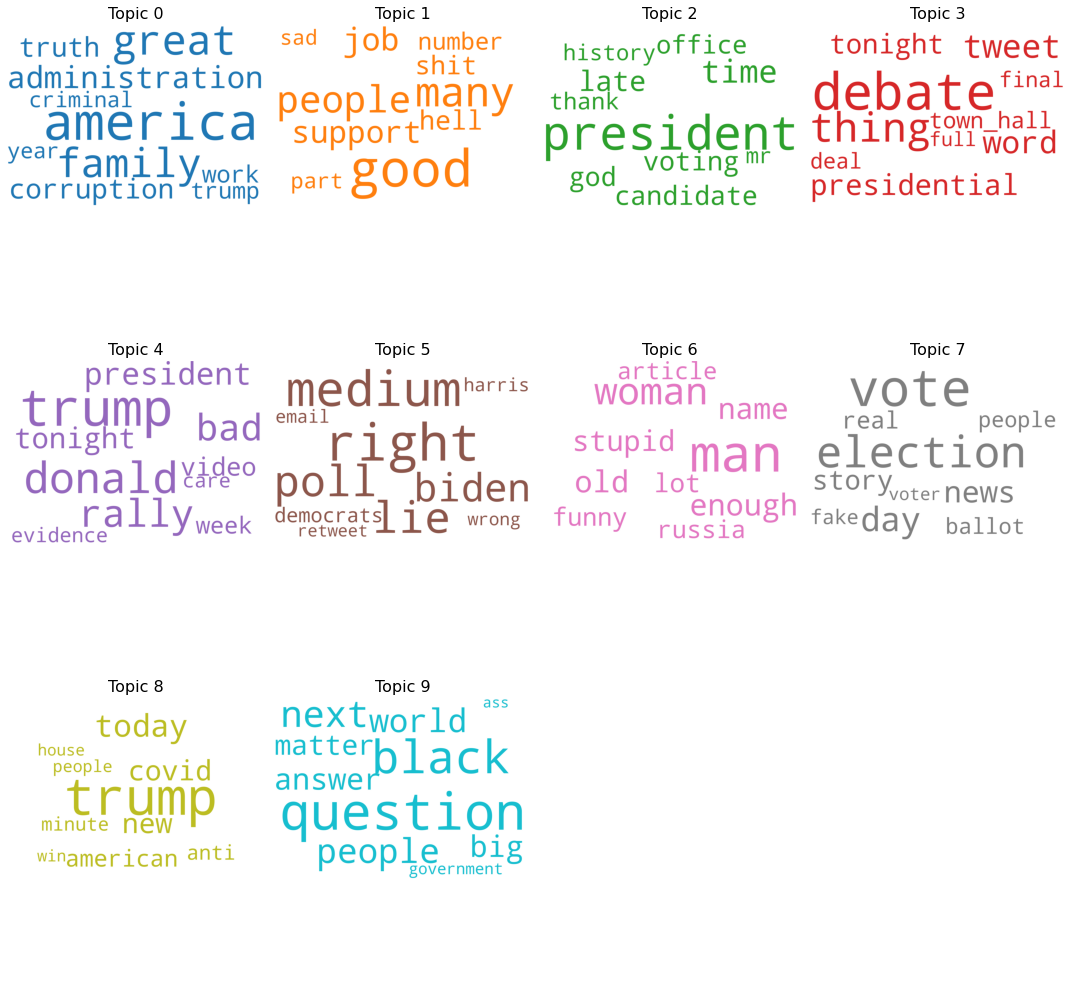

In [52]:
topics = lda_model.show_topics(formatted=False, num_topics=10) # Get top 10 topics
create_word_cloud(topics, 3, 4, color_theme=mcolors.TABLEAU_COLORS.items())

In [20]:
# Compute best k value for number of topics
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics,
                                       random_state=42,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [21]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, \
                                                        corpus=corpus, \
                                                        texts=data_lemmatized, \
                                                        start=2, \
                                                        limit=40, \
                                                        step=5)

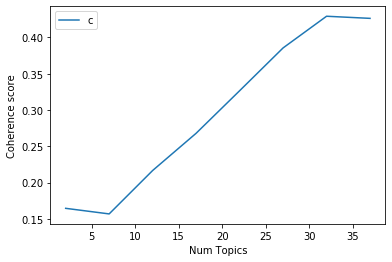

In [22]:
# Best k value
limit=40; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [53]:
# Build LDA model
optimal_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=30,
                                       random_state=42,
                                       chunksize=1000,
                                       passes=10,
                                       per_word_topics=True)

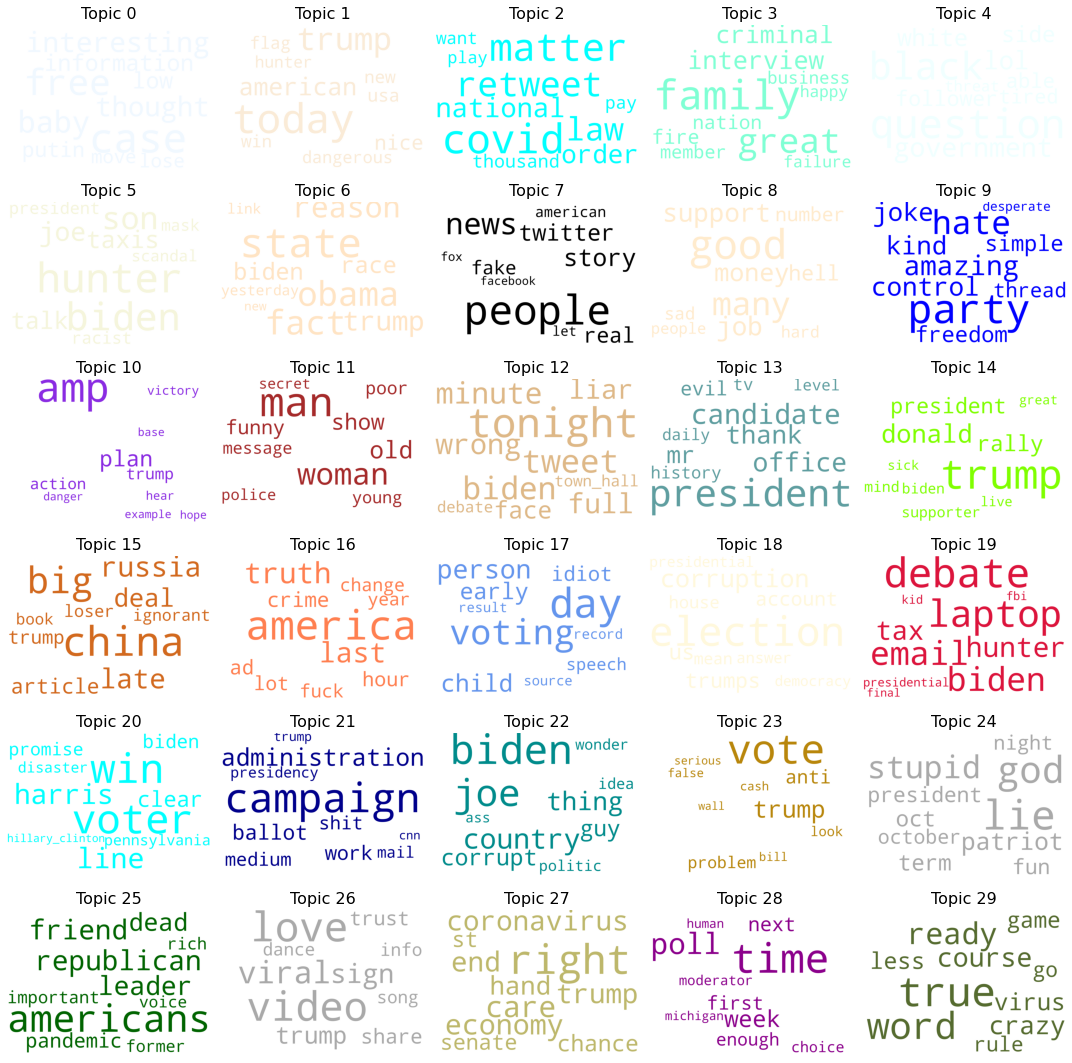

In [57]:
opt_topics = optimal_model.show_topics(formatted=False, num_topics=-1) # Get all topics
create_word_cloud(opt_topics, 6, 5, color_theme=mcolors.CSS4_COLORS.items())

In [58]:
# Compute Perplexity
print('\nPerplexity: ', optimal_model.log_perplexity(corpus))

# Compute Coherence Score
coherence_model_opt = CoherenceModel(model=optimal_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda_opt = coherence_model_opt.get_coherence()
print('\nCoherence Score: ', coherence_lda_opt)


Perplexity:  -11.149578122616878

Coherence Score:  0.37329065121179694


In [ ]:
# Build LDASeq model
seq_model = gensim.models.LdaSeqModel(corpus=corpus,
                                       time_slice=time_slices,
                                       id2word=id2word,
                                       num_topics=30,
                                       random_state=42,
                                       chunksize=1000,
                                       passes=10)

C:\Users\Dillo\Anaconda3\envs\DEV\lib\site-packages\gensim\models\ldaseqmodel.py:1474: RuntimeWarning: invalid value encountered in double_scalars
  converged = np.fabs((lhood_old - lhood) / (lhood_old * total))
C:\Users\Dillo\Anaconda3\envs\DEV\lib\site-packages\gensim\models\ldaseqmodel.py:293: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)
C:\Users\Dillo\Anaconda3\envs\DEV\lib\site-packages\gensim\models\ldaseqmodel.py:1474: RuntimeWarning: invalid value encountered in double_scalars
  converged = np.fabs((lhood_old - lhood) / (lhood_old * total))
C:\Users\Dillo\Anaconda3\envs\DEV\lib\site-packages\gensim\models\ldaseqmodel.py:1474: RuntimeWarning: invalid value encountered in double_scalars
  converged = np.fabs((lhood_old - lhood) / (lhood_old * total))
C:\Users\Dillo\Anaconda3\envs\DEV\lib\site-packages\gensim\models\ldaseqmodel.py:1474: RuntimeWarning: invalid value encountered in double_scalars
  converged =